# Japanese Temperature Data Collection
This is a companion to the other Japanese Meteorological Agency notebook on Sakura Data processing.


Sources:
* https://www.data.jma.go.jp/obd/stats/data/mdrr/man/kansoku_gaiyou.html  (smater.index file)
* https://www.data.jma.go.jp/gmd/risk/obsdl/index.php Temperature Request site

Notes:
I'm really hoping this smaster file has the data I need. Well not so much the data as it is the station identifiers that get used in the POST requests to the other link.

Notes2:
This data file has the data I need! HOORAY! Well at least part of it, the station numbers match up with the last 3 digits of the requests I manually put in for Kyoto, Nara, and Osaka

In [1]:
import sys
import pandas as pd
import numpy as np
import requests as req
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from io import StringIO

In [2]:
with open('Japan Temp Data/smaster.index', encoding='shift_jis') as file:
    for i in range(5):
        line = file.readline()
        print(line)


401 18343       ﾜﾂｶﾅｲ   WAKKANAI    4524901414070        32    11961010119651231　　　　　　　　　　　　　　　　　　　                            

401 18143       ﾜﾂｶﾅｲ   WAKKANAI    4524901414070        32    11966010119661231　　　　　　　　　　　　　　　　　　　                            

401 18573       ﾜﾂｶﾅｲ   WAKKANAI    4524901414070        32    11967010119671231　　　　　　　　　　　　　　　　　　　                            

401 18578       ﾜﾂｶﾅｲ   WAKKANAI    4524901414070        32    11968010119681231　　　　　　　　　　　　　　　　　　　                            

401 18578       ﾜﾂｶﾅｲ   WAKKANAI    4524901414070       109    11969010119701231　　　　　　　　　　　　　　　　　　　                            



In [3]:
col_widths = [3 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,2 ,1 ,1 ,8 ,12 ,6 ,7,5 ,5 ,3 ,1 ,1 ,8 ,8 ,12 ,18 ,8 ,5 ,12 ,1 ,1 ,1 ,1 ,1 ,1 ,5]

with open('Japan Temp Data/smaster.index', encoding='shift_jis') as file:
    smaster = pd.read_fwf(file,header=None,widths=col_widths,dtype='object')

In [4]:
np.unique(smaster.loc[smaster[14] == 'SAPPORO'][[0,14]])

array(['412', 'SAPPORO'], dtype=object)

In [5]:
site_list = smaster[[0,14]].drop_duplicates()
site_list.rename(columns={0:'Site Id',14:'Site Name'},inplace=True)

site_list['Site Id'] = 's47' + site_list['Site Id']
site_list['Site Name'] = site_list['Site Name'].str.title()

In [6]:
site_list.loc[site_list['Site Name'] == 'Kyoto']

,Site Id,Site Name
1845,s47759,Kyoto


In [69]:
site_list.loc[site_list['Site Name'] == 'Kyoto','Site Id'].values[0]

's47759'

IDEA: get to the index.php first, see if I get a cookie that ends in CORS, and use that cookie to make the post request

For posterity

JQuery that selects Osaka once the prefecture is loaded.

$("div.station.stmark[title*='大阪']").last()[0].click()

In [95]:
def download_site_data(station_number, start_year):
    """Downloads a CSV for a particular site from the Japanese Meteorological Agency"""

    originating_url = 'https://www.data.jma.go.jp/gmd/risk/obsdl/index.php'
    data_url = 'https://www.data.jma.go.jp/gmd/risk/obsdl/show/table'

    sess = req.session()

    orig_page = sess.get(originating_url)
    orig_soup = BeautifulSoup(orig_page.content)
    
    post_data = {'stationNumList': f'["{station_number}"]',
    'aggrgPeriod': 1,
    'elementNumList': '[["201",""]]',
    'interAnnualFlag': 1,
    'ymdList': f'["{start_year}","{start_year+1}","1","1","1","1"]',
    'optionNumList': '[]',
    'downloadFlag': True,
    'rmkFlag': 1,
    'disconnectFlag': 1,
    'youbiFlag': 0,
    'fukenFlag': 0,
    'kijiFlag': 0,
    'huukouFlag': 0,
    'csvFlag': 1,
    'jikantaiFlag': 0,
    'jikantaiList': '[]',
    'ymdLiteral': 1,
    'PHPSESSID':  orig_soup.select('#sid')[0]['value'] }

    response = sess.post(data_url,data=post_data)
    
    if "comma" in response.headers['Content-Type']:
        ## We got useful stuff
        site_df = pd.read_csv(StringIO(response.text), skiprows=5,
                              names=['Date','Avg Temp', 'Data Quality tn', 'Data Homogeneity tn'],
                              parse_dates=[0])
        site_df.set_index('Date',inplace=True)
        return site_df
    elif "html" in response.headers['Content-Type']:
        ## We got an error page. This can be expected if the site number is incorrect. Or somethign else in the POST
        ##  request is malformed.
        print("HTML Error Page Receieved")
        return
    else:
        ## Here there be dragons
        print(f"Unepxeced Content Type Received: {response.headers['Content-Type']}")
        return


In [98]:
kyoto_2020 = download_site_data('s47759', 2020)
kyoto_2019 = download_site_data('s47759', 2019)


In [101]:
kyoto_2020

,Avg Temp,Data Quality tn,Data Homogeneity tn
Date,,,
2020-01-01,5.5,8,1
2020-01-02,6.1,8,1
2020-01-03,6.9,8,1
2020-01-04,7.7,8,1
2020-01-05,5.2,8,1
...,...,...,...
2020-12-28,8.4,8,1
2020-12-29,7.8,8,1
2020-12-30,6.9,8,1


In [71]:
# Code for Posterity
headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Content-Type': "application/x-www-form/urlencoded",
    'Host': 'www.data.jma.go.jp',
    'Origin': 'https://www.data.jma.go.jp',
    'Referer': 'https://www.data.jma.go.jp/gmd/risk/obsdl/index.php'}

In [74]:
print(response.ok)
print(response.status_code)
print(response.headers['Content-Type'])
print(response.headers['Content-Type'] == '"text/x-comma-separated-values"')
print("comma" in response.headers['Content-Type'])
print("html" in response.headers['Content-Type'])
print(response.request.body)
print(response.request.headers)

print(response.text)

True
200
"text/x-comma-separated-values"
True
True
False
stationNumList=%5B%22s47759%22%5D&aggrgPeriod=1&elementNumList=%5B%5B%22201%22%2C%22%22%5D%5D&interAnnualFlag=1&ymdList=%5B%222020%22%2C%222021%22%2C%221%22%2C%221%22%2C%221%22%2C%221%22%5D&optionNumList=%5B%5D&downloadFlag=True&rmkFlag=1&disconnectFlag=1&youbiFlag=0&fukenFlag=0&kijiFlag=0&huukouFlag=0&csvFlag=1&jikantaiFlag=0&jikantaiList=%5B%5D&ymdLiteral=1&PHPSESSID=b813494l35cfnd98ks7njmqip4
{'User-Agent': 'python-requests/2.24.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'Cookie': 'AWSALB=pUOWfHYrTtCVzOQgQl+HL6q9XXzWwITq46AHd0A3Z8xThjyDR9S06piFIfMdeaYpZ3WrdB+/M1JNv72xOkV+1hactOVhnIX+ONPABki/WaikGONSh6hoMFKRDums; AWSALBCORS=pUOWfHYrTtCVzOQgQl+HL6q9XXzWwITq46AHd0A3Z8xThjyDR9S06piFIfMdeaYpZ3WrdB+/M1JNv72xOkV+1hactOVhnIX+ONPABki/WaikGONSh6hoMFKRDums', 'Content-Length': '398', 'Content-Type': 'application/x-www-form-urlencoded'}
_E[hµ½F2021/06/11 23:00:51

,s,s,s
N

In [75]:
testcase = BeautifulSoup(response.content)
testdates = StringIO(testcase.p.text)
print(testcase)

<html><body><p>ダウンロードした時刻：2021/06/11 23:00:51

,京都,京都,京都
年月日,平均気温(℃),平均気温(℃),平均気温(℃)
,,品質情報,均質番号
2020/1/1,5.5,8,1
2020/1/2,6.1,8,1
2020/1/3,6.9,8,1
2020/1/4,7.7,8,1
2020/1/5,5.2,8,1
2020/1/6,5.8,8,1
2020/1/7,5.7,8,1
2020/1/8,11.2,8,1
2020/1/9,9.6,8,1
2020/1/10,7.5,8,1
2020/1/11,6.8,8,1
2020/1/12,6.8,8,1
2020/1/13,7.7,8,1
2020/1/14,5.9,8,1
2020/1/15,6.0,8,1
2020/1/16,5.5,8,1
2020/1/17,6.7,8,1
2020/1/18,7.3,8,1
2020/1/19,6.6,8,1
2020/1/20,8.4,8,1
2020/1/21,6.7,8,1
2020/1/22,6.5,8,1
2020/1/23,9.2,8,1
2020/1/24,10.6,8,1
2020/1/25,7.7,8,1
2020/1/26,9.0,8,1
2020/1/27,8.6,8,1
2020/1/28,12.3,8,1
2020/1/29,11.1,8,1
2020/1/30,7.9,8,1
2020/1/31,5.1,8,1
2020/2/1,5.8,8,1
2020/2/2,6.3,8,1
2020/2/3,7.5,8,1
2020/2/4,6.5,8,1
2020/2/5,4.5,8,1
2020/2/6,2.0,8,1
2020/2/7,3.2,8,1
2020/2/8,5.2,8,1
2020/2/9,2.5,8,1
2020/2/10,3.0,8,1
2020/2/11,5.2,8,1
2020/2/12,8.1,8,1
2020/2/13,13.1,8,1
2020/2/14,10.8,8,1
2020/2/15,9.9,8,1
2020/2/16,11.7,8,1
2020/2/17,7.3,8,1
2020/2/18,3.8,8,1
2020/2/19,7.1,8,1
2020/2/20,7.6,

In [84]:
testcase = BeautifulSoup(response.content)
testdates = StringIO(testcase.p.text)
derpy = StringIO(response.text)
test_df = pd.read_csv(testdates,skiprows=5,names=['Date','Avg Temp', 'Data Quality tn', 'Data Homogeneity tn'],parse_dates=[0])
test_df2 = pd.read_csv(StringIO(response.text),skiprows=5,names=['Date','Avg Temp', 'Data Quality tn', 'Data Homogeneity tn'],parse_dates=[0])
test_df2

,Date,Avg Temp,Data Quality tn,Data Homogeneity tn
0,2020-01-01,5.5,8,1
1,2020-01-02,6.1,8,1
2,2020-01-03,6.9,8,1
3,2020-01-04,7.7,8,1
4,2020-01-05,5.2,8,1
...,...,...,...,...
362,2020-12-28,8.4,8,1
363,2020-12-29,7.8,8,1
364,2020-12-30,6.9,8,1
365,2020-12-31,2.1,8,1


In [87]:
test_df2.set_index('Date')

,Avg Temp,Data Quality tn,Data Homogeneity tn
Date,,,
2020-01-01,5.5,8,1
2020-01-02,6.1,8,1
2020-01-03,6.9,8,1
2020-01-04,7.7,8,1
2020-01-05,5.2,8,1
...,...,...,...
2020-12-28,8.4,8,1
2020-12-29,7.8,8,1
2020-12-30,6.9,8,1


<AxesSubplot:title={'center':'Daily Temperatures in Kyoto'}, xlabel='Date', ylabel='Aveage Temperate in C'>

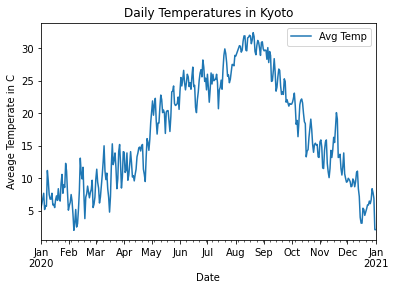

In [107]:
test_df.plot('Date','Avg Temp',ylabel='Aveage Temperate in C',title='Daily Temperatures in Kyoto')